### Competition Objective

![Elo](https://www.cloudera.com/content/dam/www/marketing/images/logos/customers/cartao-elo.png)

[Elo](https://www.cartaoelo.com.br/), one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders.  The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.

### Objective of the Notebook

Objevtive of the notebook is to explore the given data and get some interesting insights which will help in our model building process.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

/Users/helloword/Develop/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



### Dataset Exploration

In this part, let us look at the given files before we get into data exploration.

In [2]:
!ls ../data/

Data Dictionary.xlsx          new_merchant_transactions.csv
Data_Dictionary.xlsx          sample_submission.csv
historical_transactions.csv   test.csv
merchants.csv                 train.csv


So we are given the above files. The description of the files are

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
* historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset.
* new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

First let us explore the train and test set.

In [3]:
train_df = pd.read_csv("../data/train.csv" , parse_dates = ["first_active_month"])
test_df = pd.read_csv("../data/test.csv" , parse_dates = ["first_active_month"])
print("Number of rows and columns in train set : " , train_df.shape)
print("Number of rows and columns in test set : " , test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [4]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
def distplot(x,col):
    plt.figure(figsize=(14,10))
    sns.distplot(x[col])
    plt.show()

### Target Column Exploration:

In this section, let us explore the target column

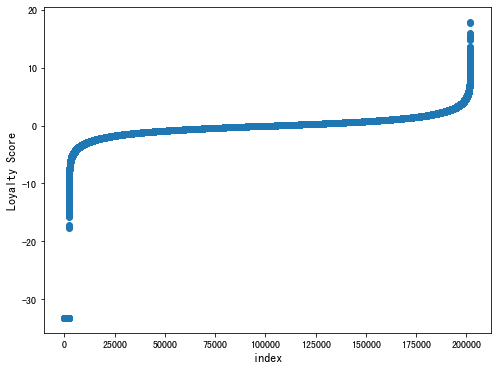

In [6]:
target_col = "target"

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()
# loyalty 居中的是大多数，极高和极低的是少数, 样本呈正态

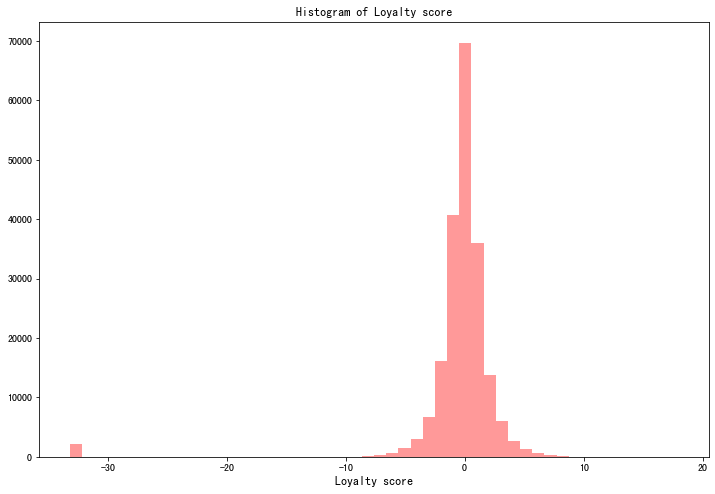

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

We can see that some of the loyalty values are far apart (less than -30) compared to others. Let us just get their count.

In [8]:
(train_df[target_col]<-30).sum()

2207

We have about 2207 rows (almost 1% of the data), which has values different from the rest. Since the metric RMSE these rows might play an important role. So beware of them.

In [9]:
train_df['first_active_month'].dt.date.value_counts()

2017-09-01    13878
2017-10-01    13695
2017-08-01    13638
2017-11-01    12930
2017-07-01    12363
              ...  
2012-03-01       10
2011-11-01        8
2012-02-01        7
2011-12-01        2
2018-02-01        1
Name: first_active_month, Length: 75, dtype: int64

### First Active Month

In this section, let us see if there are any distribution change between train and test sets with respect to first active month of the card.

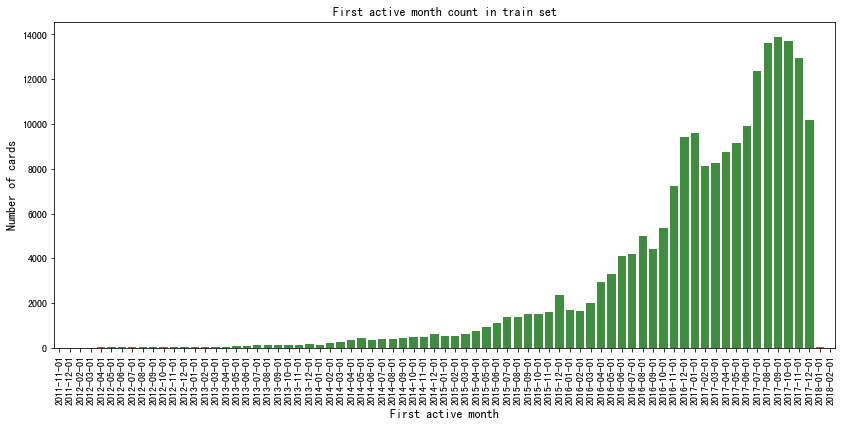

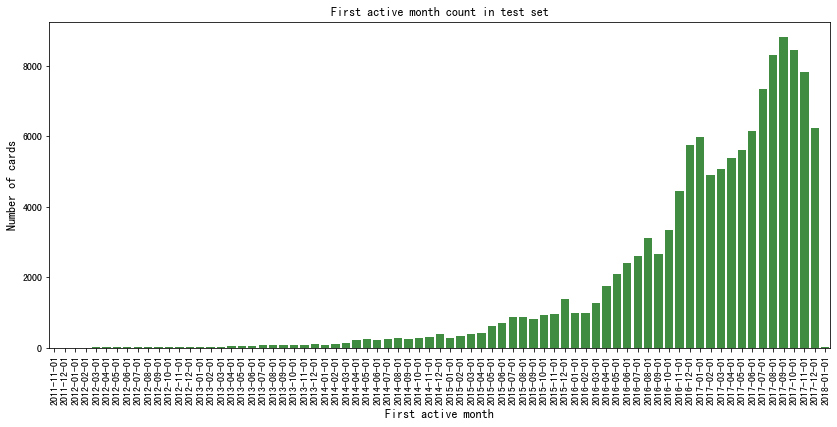

In [10]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

Looks like the distribution is kind of similar between train and test set. So we need not really have to do time based split I think.

### Feature 1,2 & 3:

In this section, let us see if the other variables in the train dataset has good predictive power in finding the loyalty score.

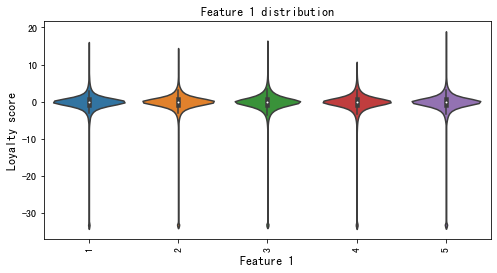

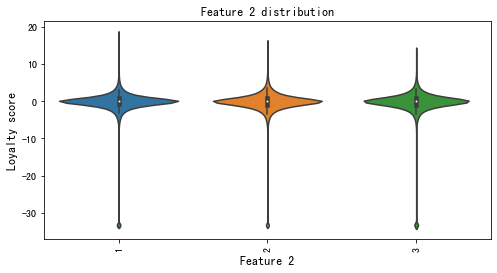

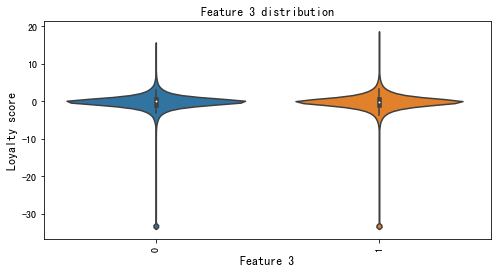

In [11]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y=target_col, data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feature 3 distribution")
plt.show()

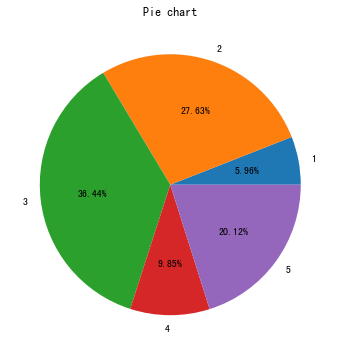

In [12]:
labels,counts = np.unique(train_df['feature_1'] , return_counts=True)

fig = plt.figure(figsize=(8,6))
plt.pie(counts,labels=labels,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Pie chart")
plt.show()  

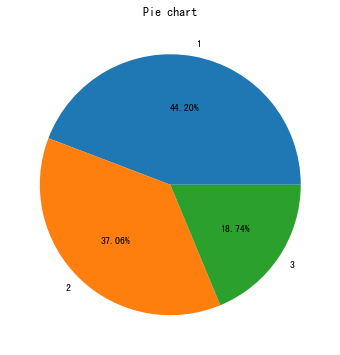

In [13]:
labels,counts = np.unique(train_df['feature_2'] , return_counts=True)

fig = plt.figure(figsize=(8,6))
plt.pie(counts,labels=labels,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Pie chart")
plt.show()  

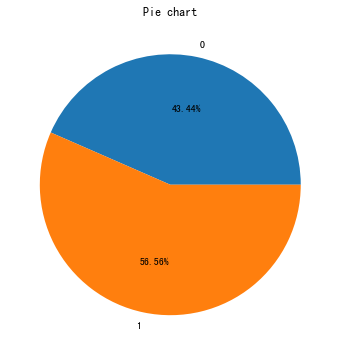

In [14]:
labels,counts = np.unique(train_df['feature_3'] , return_counts=True)

fig = plt.figure(figsize=(8,6))
plt.pie(counts,labels=labels,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Pie chart")
plt.show()  

In [15]:
def plot_pie(x):
    labels,counts = np.unique(x , return_counts=True)
    fig = plt.figure(figsize=(8,6))
    plt.pie(counts,labels=labels,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
    plt.title("Pie chart")
    plt.show()

In [16]:
def plot_count(df,col):
    plt.figure(figsize=(12,4))
    sns.countplot(data=df,x=col).set_title('count')
    plt.show()

To the naked eyes, the distribution of the different categories in all three features look kind of similar. May be the models are able to find something here. 

### Historical Transactions:

Now let us look at the historical transactions data for the cards.

In [17]:
hist_df = pd.read_csv("../data/historical_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


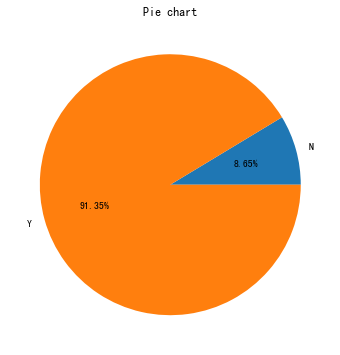

In [18]:
plot_pie(hist_df['authorized_flag'])

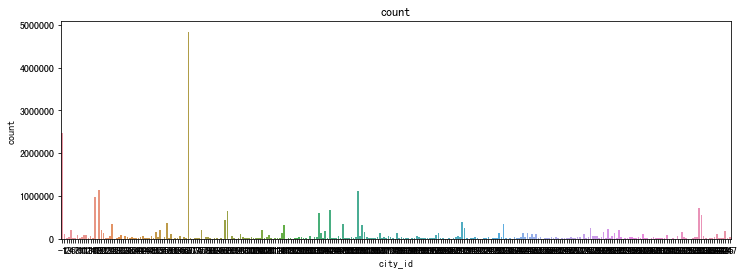

In [19]:
plot_count(hist_df,'city_id')

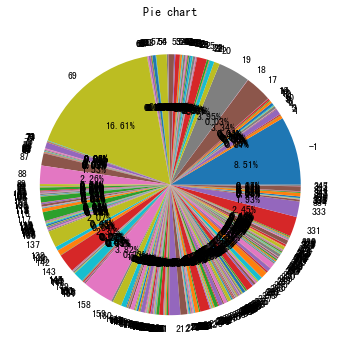

In [20]:
plot_pie(hist_df['city_id'])

The field descriptions are as follows:

* card_id	- Card identifier
* month_lag	- month lag to reference date
* purchase_date	- Purchase date
* authorized_flag -	'Y' if approved, 'N' if denied
* category_3 - anonymized category
* installments -	number of installments of purchase
* category_1 -	anonymized category
* merchant_category_id -	Merchant category identifier (anonymized )
* subsector_id -	Merchant category group identifier (anonymized )
* merchant_id -	Merchant identifier (anonymized)
* purchase_amount -	Normalized purchase amount 标准化后的 purchase amount
* city_id -	City identifier (anonymized )
* state_id -	State identifier (anonymized )
* category_2 -	anonymized category

Now let us make some features based on the historical transactions and merge them with train and test set.

#### Number of Historical Transactions for the card

In [22]:
gd = hist_df.groupby("card_id")["purchase_amount"].size().reset_index()
gd.columns = ["card_id", "num_hist_transactions"]
gd

,card_id,num_hist_transactions
0,C_ID_00007093c1,149
1,C_ID_0001238066,123
2,C_ID_0001506ef0,66
3,C_ID_0001793786,216
4,C_ID_000183fdda,144
...,...,...
325535,C_ID_ffff1d9928,12
325536,C_ID_ffff579d3a,114
325537,C_ID_ffff756266,24
325538,C_ID_ffff828181,190


In [23]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [24]:
train_df['num_hist_transactions'].value_counts()

15      2662
18      2595
20      2577
13      2523
14      2521
        ... 
948        1
1142       1
1076       1
1204       1
1256       1
Name: num_hist_transactions, Length: 1023, dtype: int64

In [25]:
gd.index

RangeIndex(start=0, stop=325540, step=1)

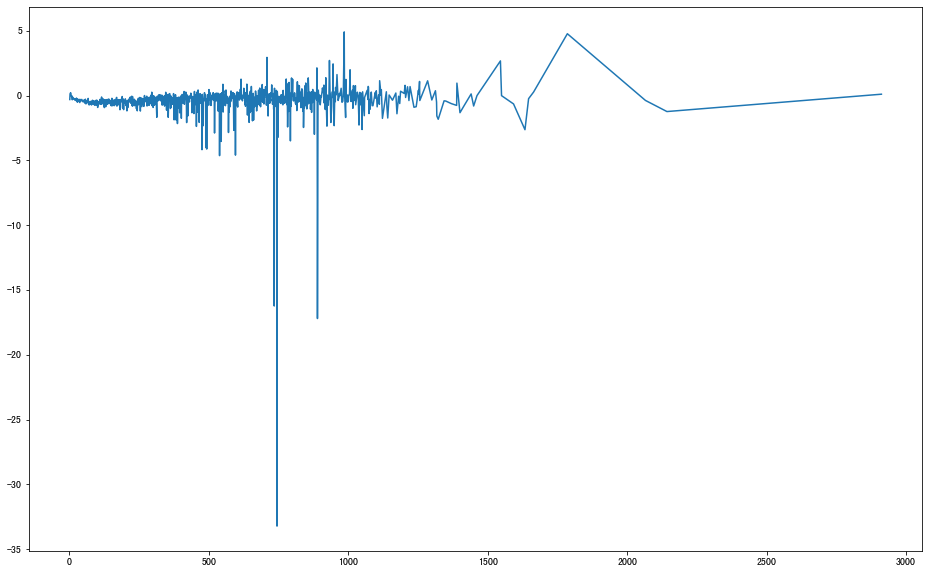

In [26]:
gd = train_df.groupby("num_hist_transactions")[target_col].mean().sort_index()
plt.figure(figsize=(16,10))
plt.plot(gd.index.values,gd.values)
plt.show()

In [27]:
cnt_srs.index[::-1]

Index([2018-01-01, 2017-12-01, 2017-11-01, 2017-10-01, 2017-09-01, 2017-08-01,
       2017-07-01, 2017-06-01, 2017-05-01, 2017-04-01, 2017-03-01, 2017-02-01,
       2017-01-01, 2016-12-01, 2016-11-01, 2016-10-01, 2016-09-01, 2016-08-01,
       2016-07-01, 2016-06-01, 2016-05-01, 2016-04-01, 2016-03-01, 2016-02-01,
       2016-01-01, 2015-12-01, 2015-11-01, 2015-10-01, 2015-09-01, 2015-08-01,
       2015-07-01, 2015-06-01, 2015-05-01, 2015-04-01, 2015-03-01, 2015-02-01,
       2015-01-01, 2014-12-01, 2014-11-01, 2014-10-01, 2014-09-01, 2014-08-01,
       2014-07-01, 2014-06-01, 2014-05-01, 2014-04-01, 2014-03-01, 2014-02-01,
       2014-01-01, 2013-12-01, 2013-11-01, 2013-10-01, 2013-09-01, 2013-08-01,
       2013-07-01, 2013-06-01, 2013-05-01, 2013-04-01, 2013-03-01, 2013-02-01,
       2013-01-01, 2012-12-01, 2012-11-01, 2012-10-01, 2012-09-01, 2012-08-01,
       2012-07-01, 2012-06-01, 2012-05-01, 2012-04-01, 2012-03-01, 2012-02-01,
       2012-01-01, 2011-12-01, 2011-11-01],
      dt

In [28]:
cnt_srs = train_df.groupby("num_hist_transactions")[target_col].mean()
cnt_srs = cnt_srs.sort_index()
cnt_srs = cnt_srs[:-50]

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

trace = scatter_plot(cnt_srs, "orange")
layout = dict(
    title='Loyalty score by Number of historical transactions',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Histtranscnt")

Now let us bin the count of historical transactions and then do some box plots to see the plots better.

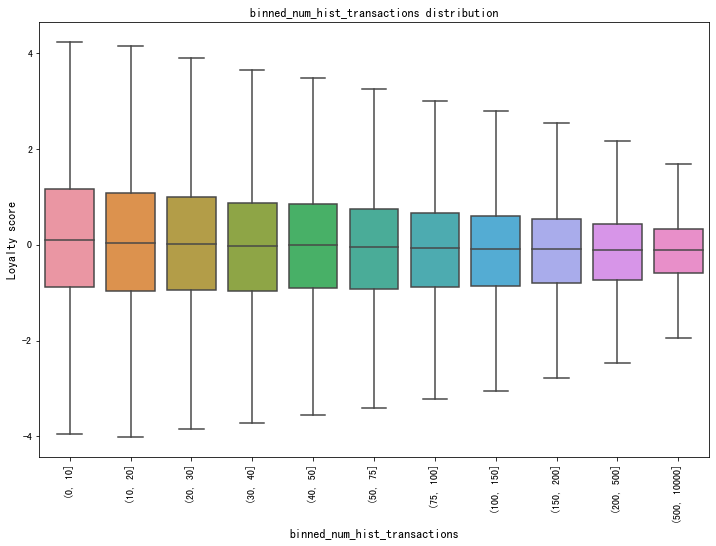

In [29]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

#### Value of Historical Transactions

Now let us check the value of the historical transactions for the cards and check the loyalty score distribution based on that.

In [30]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [31]:
train_df['sum_hist_trans']

0        -165.968739
1        -210.006336
2         -29.167391
3         -49.491364
4         -48.687656
             ...    
201912    -32.625247
201913    -33.432922
201914    -33.187479
201915    -17.888957
201916    -83.037556
Name: sum_hist_trans, Length: 201917, dtype: float64

In [32]:
bins

[0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 500, 10000]

In [33]:
np.percentile(train_df["sum_hist_trans"], range(0,101,10))

array([-2.08801253e+03, -1.24526257e+02, -7.86008824e+01, -5.58641381e+01,
       -4.10573860e+01, -3.03869428e+01, -2.21086120e+01, -1.54013812e+01,
       -9.77993008e+00, -4.36994103e+00,  6.01059606e+06])

In [34]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
train_df['binned_sum_hist_trans']

0         (-2088.013, -124.526]
1         (-2088.013, -124.526]
2            (-30.387, -22.109]
3            (-55.864, -41.057]
4            (-55.864, -41.057]
                  ...          
201912       (-41.057, -30.387]
201913       (-41.057, -30.387]
201914       (-41.057, -30.387]
201915       (-22.109, -15.401]
201916      (-124.526, -78.601]
Name: binned_sum_hist_trans, Length: 201917, dtype: category
Categories (10, interval[float64]): [(-2088.013, -124.526] < (-124.526, -78.601] < (-78.601, -55.864] < (-55.864, -41.057] ... (-22.109, -15.401] < (-15.401, -9.78] < (-9.78, -4.37] < (-4.37, 6010596.057]]

In [35]:
train_df['sum_hist_trans']

0        -165.968739
1        -210.006336
2         -29.167391
3         -49.491364
4         -48.687656
             ...    
201912    -32.625247
201913    -33.432922
201914    -33.187479
201915    -17.888957
201916    -83.037556
Name: sum_hist_trans, Length: 201917, dtype: float64

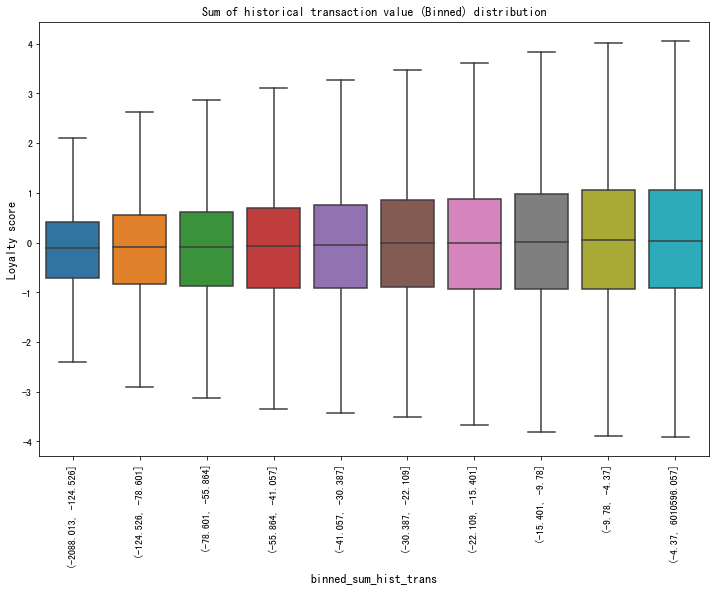

In [36]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x = "binned_sum_hist_trans", y = target_col, data = train_df, showfliers = False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of historical transaction value (Binned) distribution")
plt.show()

As we could see, the loyalty score seem to increase with the "sum of historical transaction value". This is expected. Now we can do the same plot with "Mean value of historical transaction".

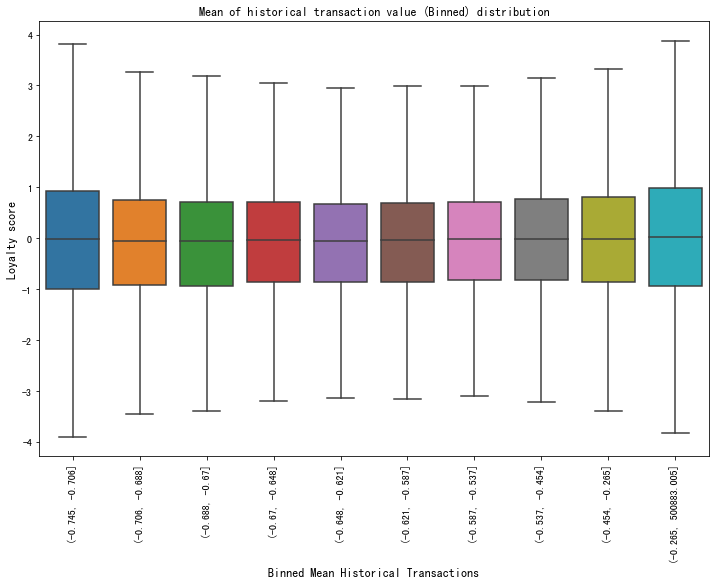

In [37]:
bins = np.percentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_mean_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of historical transaction value (Binned) distribution")
plt.show()

### New Merchant Transactions

In this section, let us look at the new merchant transactions data and do some analysis

In [38]:
new_trans_df = pd.read_csv("../data/new_merchant_transactions.csv")
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [39]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

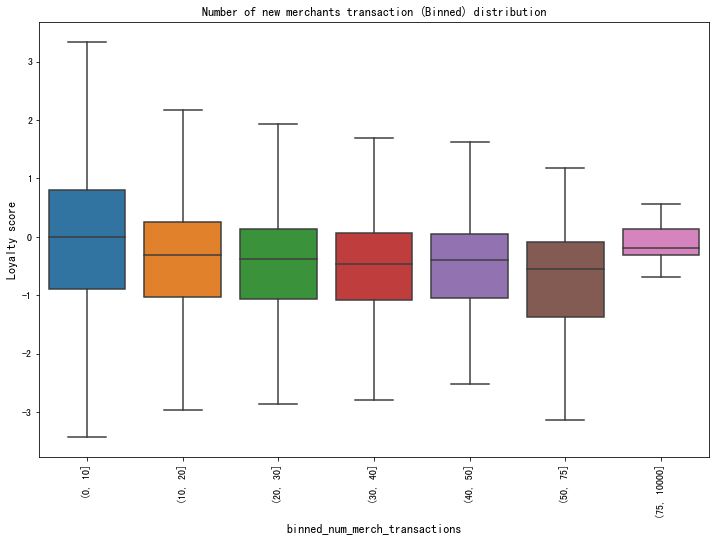

In [40]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_merch_transactions")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Number of new merchants transaction (Binned) distribution")
plt.show()

Loyalty score seem to decrease as the number of new merchant transactions increases except for the last bin. 

In [41]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

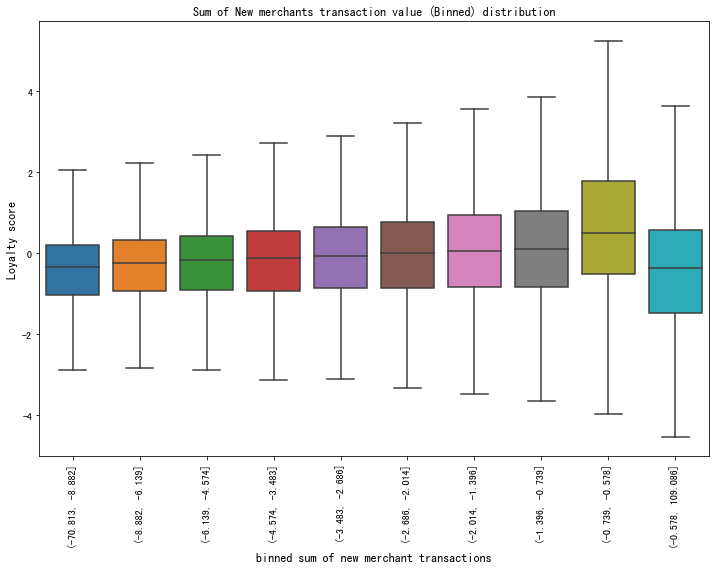

In [42]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

Loyalty scores seem to increase with the increase in the sum of new merchant transaction values but for the last bin.

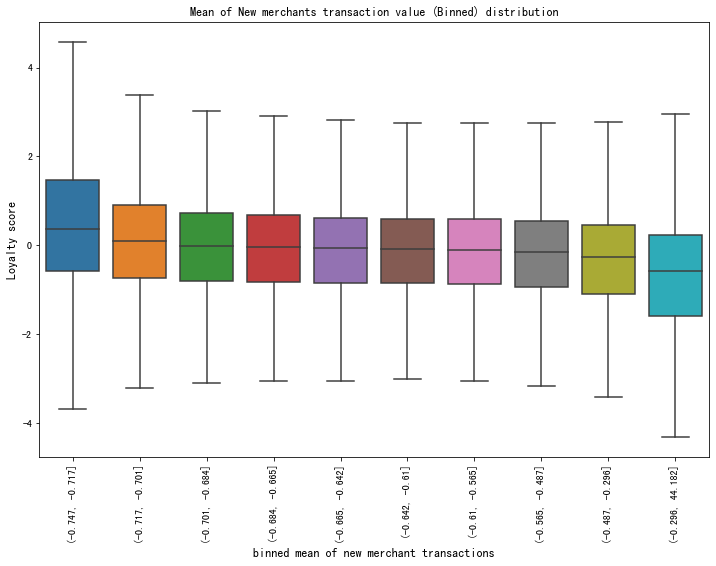

In [43]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0,101,10))
train_df['binned_mean_merch_trans'] = pd.cut(train_df['mean_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

### Baseline Model

Let us build a baseline model using the features created so far.

In [44]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", 
               "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", 
               "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans",
               "min_merch_trans", "max_merch_trans",
              ]

def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df[target_col].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81049
[200]	valid_0's rmse: 3.80984
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.80946
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75935
[200]	valid_0's rmse: 3.75958
Early stopping, best iteration is:
[151]	valid_0's rmse: 3.75848
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.80311
[200]	valid_0's rmse: 3.80228
[300]	valid_0's rmse: 3.80269
Early stopping, best iteration is:
[210]	valid_0's rmse: 3.80206
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7929
[200]	valid_0's rmse: 3.79349
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.79269
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8547
[200]	valid_0's rmse: 3.85516
Early stopping, best iteration is:
[127]	valid_0's rmse: 3.85456


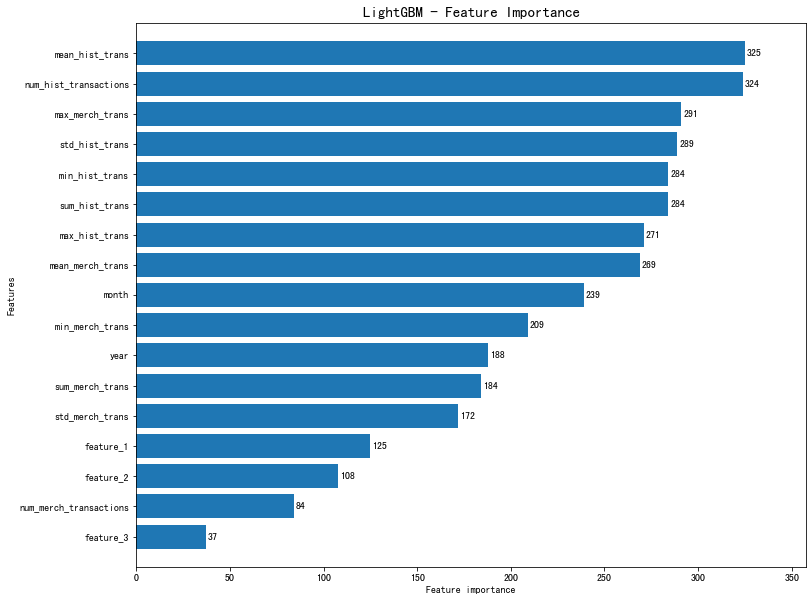

In [45]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [46]:
sub_df = pd.DataFrame({"card_id" : test_df["card_id"].values})
sub_df["target"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

Let us add more features in the upcoming versions and check the results.

**More to come. Stay Tuned.!**